In [ ]:
import pandas as pd
import numpy as np
import time
import itertools
from itertools import compress


import plotly.graph_objects as go
#from umap import UMAP
from matplotlib_venn import venn2,venn3
import matplotlib.pyplot as plt

from scipy.stats import zscore

from natsort import natsorted, ns


import seaborn as sns

#import ckg.ckg_utils as ckg_utils

#from ckg.analytics_core.analytics import analytics
#from ckg.analytics_core.viz import viz


from matplotlib.pyplot import gcf
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px

%matplotlib inline
init_notebook_mode()


In [57]:
import time
import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import prep_data, find_string_value, filter_missingness, pimms_imputation, batch_correction
import numpy as np
import plotly.express as px
import pandas as pd

In [111]:
# Blood
start_time = time.time()
proteome_filepath = '../data/plasmareport.pg_matrix.tsv'
proteome_raw = pd.read_csv(proteome_filepath, sep = '\t')
proteome_raw.loc[proteome_raw.Genes.isnull(),'Genes']= proteome_raw.loc[(proteome_raw.Genes.isnull())]['Protein.Names'].str.split(';').str[0].str.split('_').str[0]
proteome_raw['identifier']=proteome_raw['Genes'].str.split(';').str[0]+'~'+proteome_raw['Protein.Group'].str.split(';').str[0]

#info_filepath = '/Users/tzx804/projects/collaborations/nicolai/LNB/version2/data/clinical/clinical_data_combined.xlsx'
#info_filepath = '../data/revised_info.xlsx'
info_filepath = '../submission/info/clinical_data.xlsx'

pg_long_blood, exclusion_blood, pg_sub = prep_data(info_filepath, proteome_filepath, run = 'blood')
print('{} data ready --- {} minutes ---\n'.format('training',round(((time.time() - start_time)/60),3)))

Number of pool:12, blank:35, study samples:182
Number of rows (proteins) in original data, shape: 379
Empty rows removed, shape: 379
Empty id-name removed, shape: 377
Empty DataFrame
Columns: [Protein, Protein, Genes, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_102736, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_103227, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_103378, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_104244, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_104936, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_105351, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_105750, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_106362, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_110182, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_114652, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_116342, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_118151, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_120022, 20220519_EXPL11_EVO8_LNB2ndCohort_Plate1_Plasma_121617

In [112]:
# Supplementary figure 
subset_df = pg_long_blood.copy()
subset_df.LFQ_intensity = np.log2(subset_df.LFQ_intensity)
subset_df = subset_df.loc[(subset_df['study_cohort'].notnull())]
count_df = subset_df.groupby(['sample_id','study_cohort']).size().reset_index()
count_df.columns = ['samples','study_cohort','proteins']
count_df= count_df.sort_values(['study_cohort','proteins'], ascending = [False, False])
fig = px.histogram(count_df, x="proteins", 
                   marginal="box", # or violin, rug
                   hover_data=count_df.columns,
                   #nbins = 16,
                   template = 'plotly_white',
                   height = 500, width = 450)
fig.update_layout(bargap = 0.1)
fig.update_xaxes(range = [0,500])
fig.write_image('../submission/info/S6.svg', height = 400, width = 1000)
fig.show()

In [113]:
print(pg_long_blood.sample_id.unique().shape)
pg_long_blood = pg_long_blood.loc[~pg_long_blood.samples.isin(exclusion_blood)]
print(pg_long_blood.sample_id.unique().shape)

pg_long_blood.loc[:,'identifier']=pg_long_blood.name+'~'+pg_long_blood.uniprot_id

(194,)
(193,)


# Data processing

Drop 113 along axis 0.


epoch,train_loss,valid_loss,time
0,340.205353,41.699245,00:00
1,336.967743,41.564751,00:00
2,332.822235,41.176777,00:00
3,328.765869,42.093697,00:00
4,323.792908,44.060177,00:00
5,316.324982,44.057884,00:00
6,308.791748,45.944786,00:00
7,302.511688,47.772202,00:00
8,297.187256,49.387489,00:00
9,292.367126,49.581982,00:00


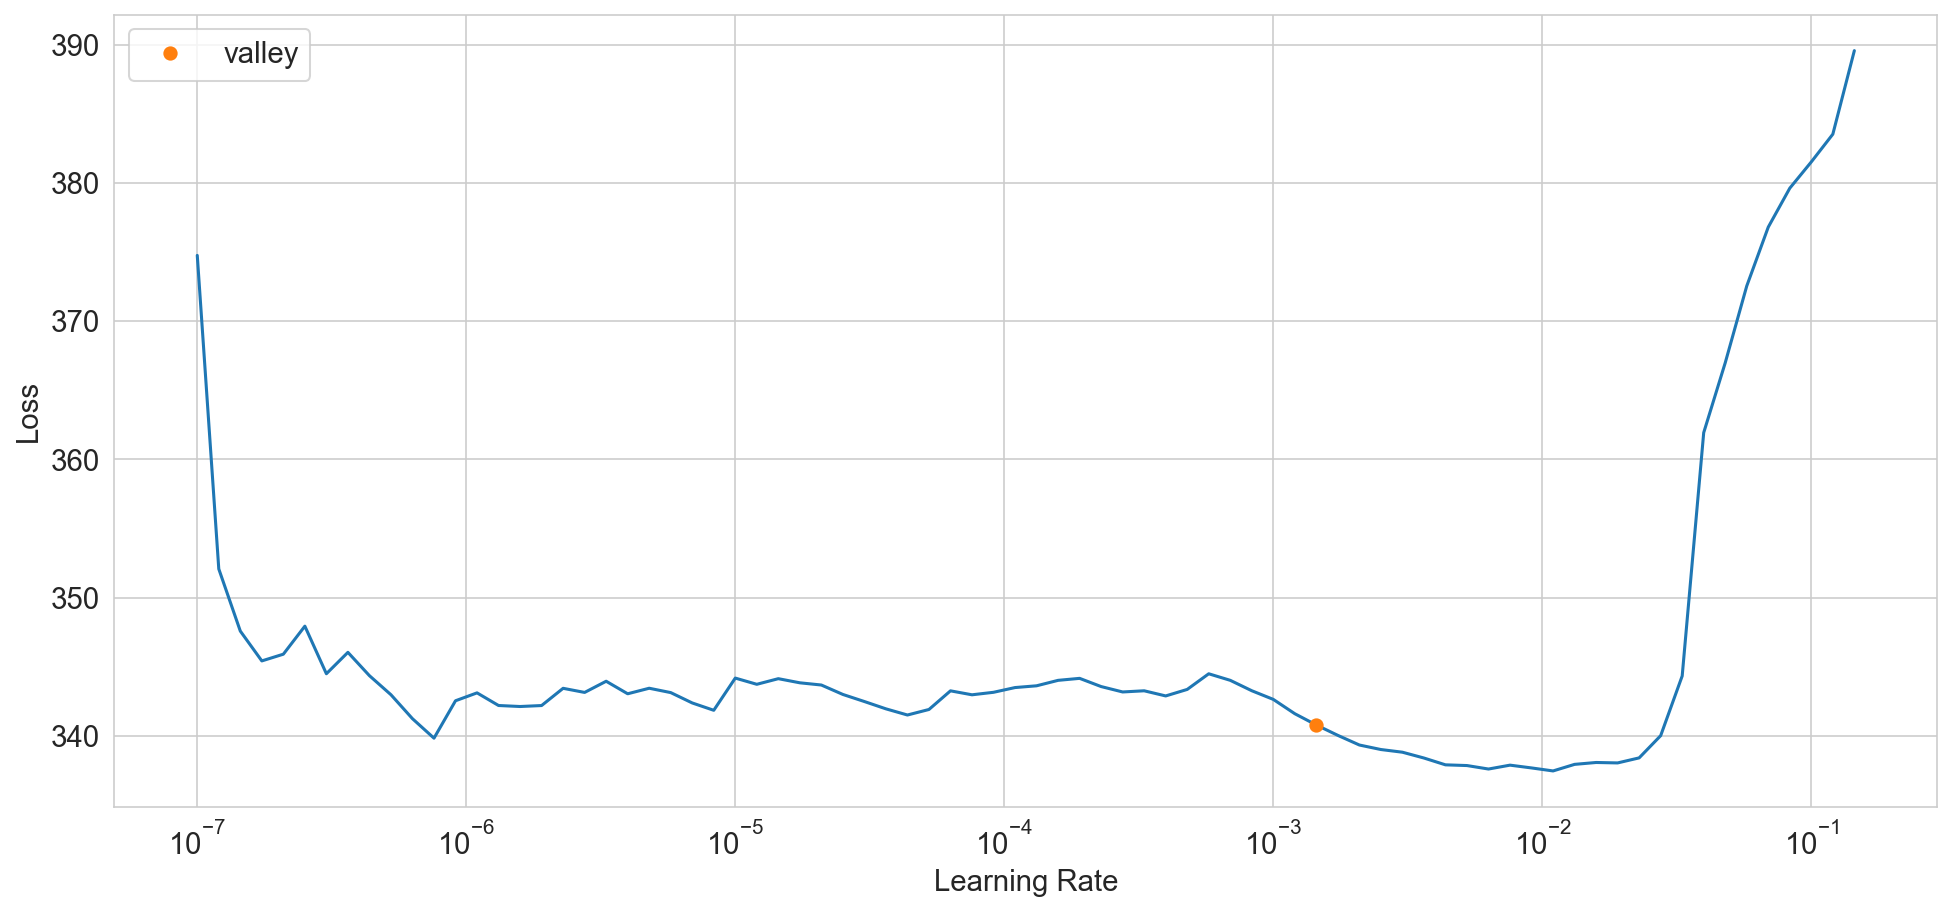

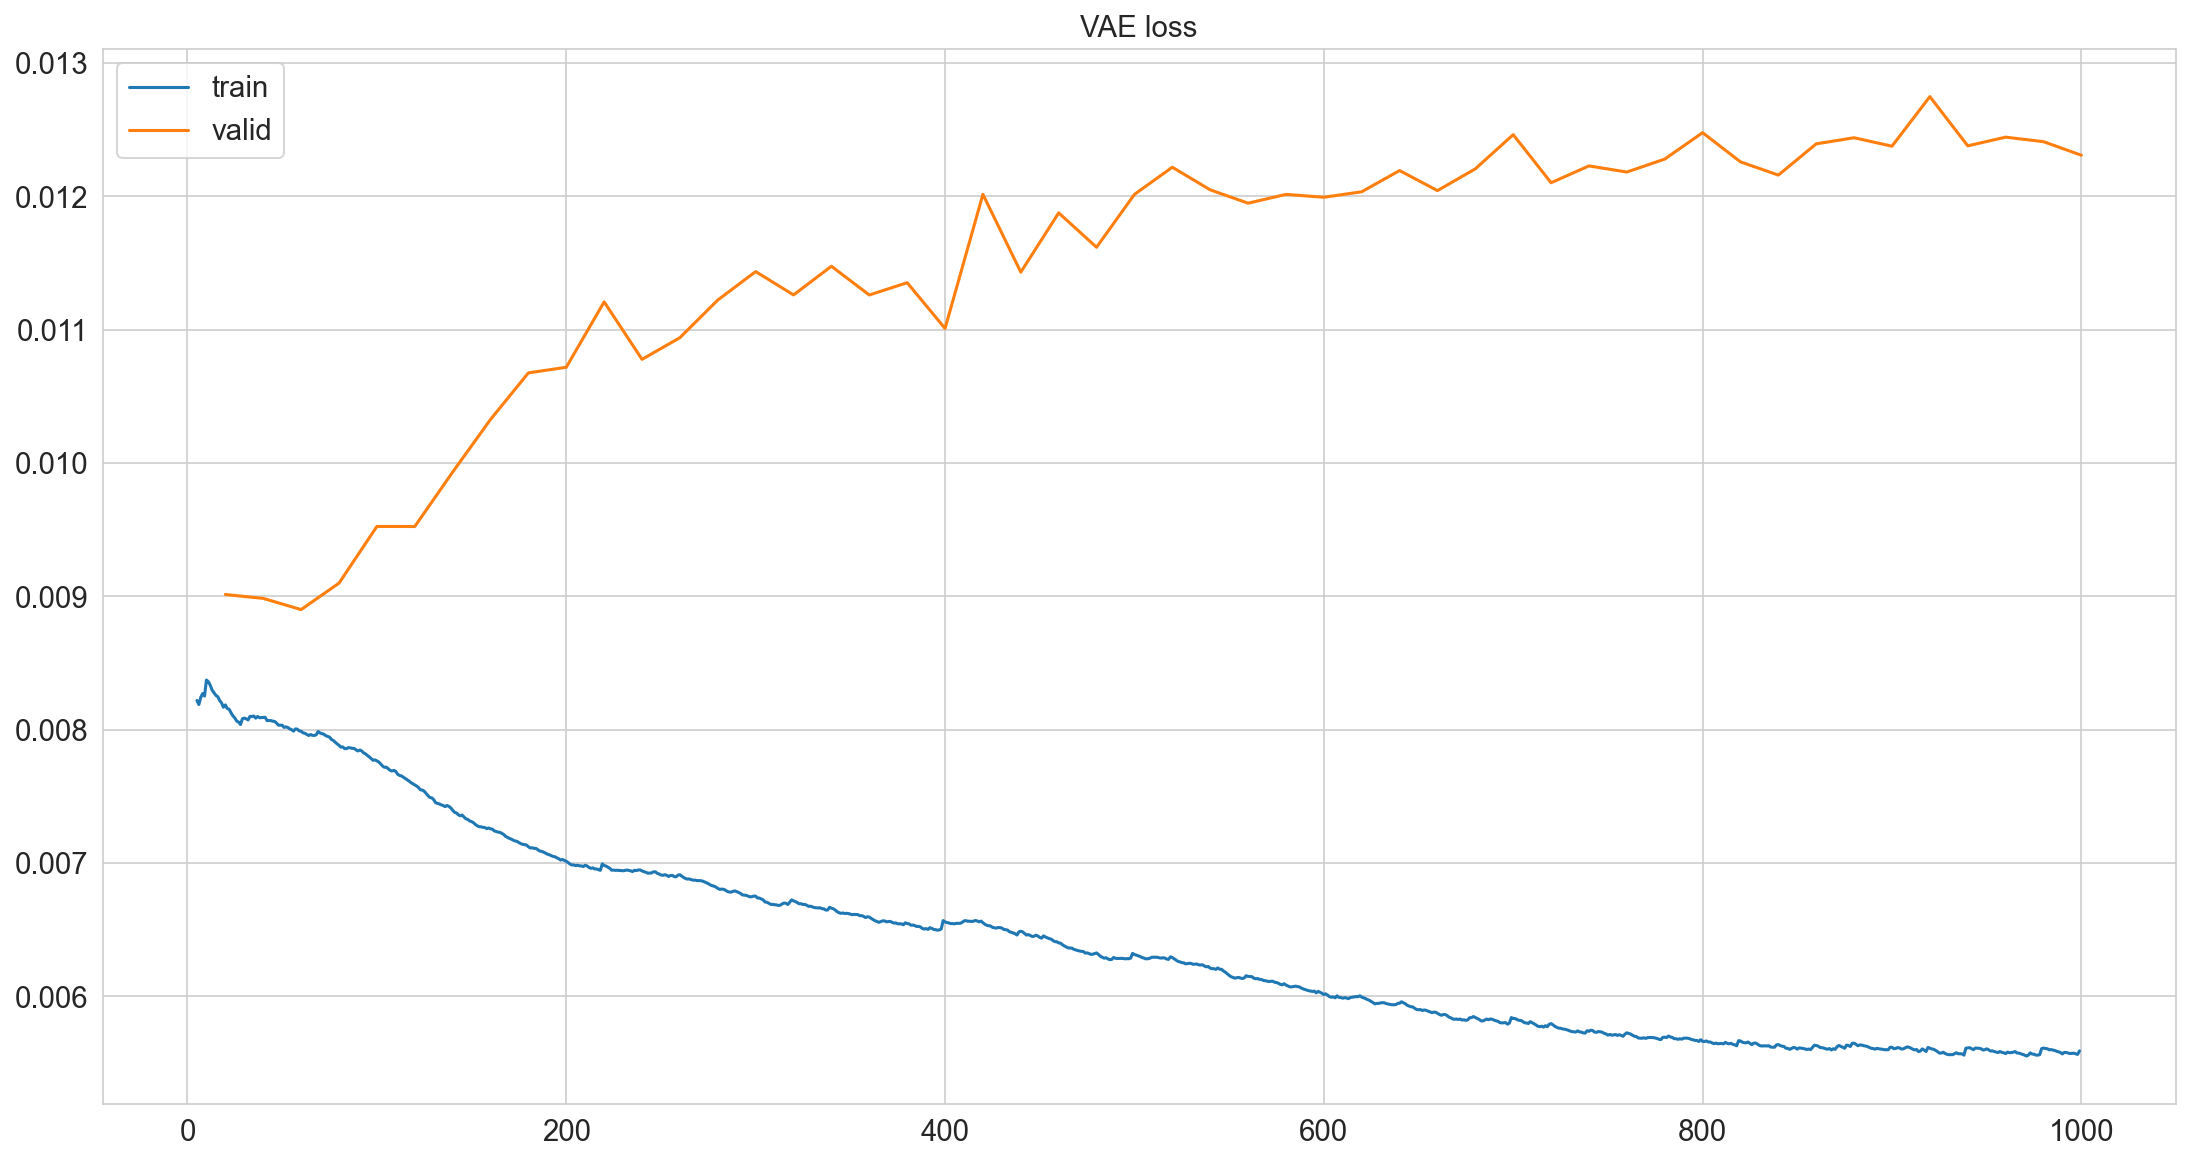

In [114]:
# 1) log transform
pg_long_blood.LFQ_intensity = np.log2(pg_long_blood.LFQ_intensity)
# from long to wide format
index_cols = ['sample_id','samples','type','batch','study_cohort','diagnosis','origin']
pg_wide = pg_long_blood.pivot(index = index_cols, columns='identifier',values = 'LFQ_intensity')
# 2) filter data on missingness (ignore QC samples)
pg_wide_sample = pg_wide.loc[pg_wide.index.get_level_values('type') == 'sample'].reset_index().drop(['samples','type','batch','study_cohort','diagnosis','origin'], axis = 1).set_index('sample_id')
filter_info = filter_missingness(pg_wide_sample, feat_prevalence=.6)
# 3) impute
df_wide = pg_wide[filter_info.columns].droplevel(['samples','type','batch','study_cohort','diagnosis','origin'])
imputed_data_blood = pimms_imputation(df_wide)

In [115]:
# 4) correct for plate effect
# add plate information
imputed_data_blood = pd.merge(pg_long_blood[['sample_id','batch','type','study_cohort']].drop_duplicates(), imputed_data_blood, left_on = 'sample_id',right_index = True, how = 'right')
imputed_data_blood.batch.fillna('No_plateinfo', inplace = True)
index_cols = ['sample_id', 'batch', 'type', 'study_cohort']
corrected_data_blood = batch_correction(imputed_data_blood.set_index(index_cols), plate_lst = imputed_data_blood.batch.tolist())


In [116]:
# info = pd.read_excel(info_filepath)
# info.sample_id = info.sample_id.astype(str)
# print(info.aetiology.value_counts())

# from datetime import datetime

# # Function to fix year for date-like strings
# def fix_year_if_needed(date_val):
#     if isinstance(date_val, (pd.Timestamp, datetime)):  # Check if the value is already a datetime object
#         return date_val
#     else:
#         # Handle string or non-datetime values
#         day, month, year = map(int, date_val.split('-'))
#         if year <= 24:
#             year += 2000  # Years <= 24 treated as 20xx
#         else:
#             year += 1900  # Years > 24 treated as 19xx
#         return pd.Timestamp(year, month, day)

# # Convert values in 'dob' column if necessary
# info['fixed_dob'] = info['dob'].apply(fix_year_if_needed)

# #info['bday'] = pd.to_datetime(info.dob)
# info['sday'] = pd.to_datetime(info.sample_date)

# info['age']=(info.sday-info.fixed_dob).dt.total_seconds() / (365.25 * 24 * 60 * 60)#/365.25 #.astype('timedelta64[Y]') 
# info.head()
# info.loc[info.diagnosis.isin(['PTLDS','EM','ACA']), 'study_cohort']='plasma_validation'
# info.to_excel('../submission/info/clinical_data.xlsx', index=False)
# info


In [117]:
# prepare data for differential data analysis
aps_meta = info[['sample_id','diagnosis','study_cohort']].drop_duplicates()
aps_meta.sample_id = aps_meta.sample_id.astype(str)
# subset to the samples (not QC samples)
aps_meta = pd.merge(aps_meta, pg_long_blood.loc[(pg_long_blood['type']=='sample')][['sample_id']].drop_duplicates(), on = 'sample_id')
# add plasma identification
aps_meta.sample_id = ['plasma'+x for x in aps_meta.sample_id.astype(str).tolist()]
aps_meta['group']=aps_meta.diagnosis.copy()
aps_meta.loc[aps_meta['group']!='LNB','group']='nonLNB'
aps_meta.to_excel('../submission/info/aps_meta_plasma.xlsx', index = None)


In [119]:
cohorts = [['plasma_development','plasma_validation'],['plasma_development'],['plasma_validation']]
names = ['plasma_combined','plasma_development','plasma_validation']
for i in range(len(cohorts)):
    cohort = cohorts[i]
    aps_data = 2**corrected_data_blood.loc[(corrected_data_blood.index.get_level_values('type')=='sample')].droplevel(['type', 'batch','study_cohort']).T
    print(aps_data.shape)
    aps_data.columns = ['plasma'+x for x in aps_data.columns.tolist()]
    aps_data = aps_data[aps_meta[aps_meta.study_cohort.isin(cohort)].sample_id.unique().tolist()]
    print(aps_data.shape)
    aps_data = pd.merge(proteome_raw[['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description','identifier']].drop_duplicates(), aps_data, left_on='identifier', right_index=True)
    aps_data.drop('identifier', axis = 1, inplace = True)
    aps_data.to_csv('../submission/info/aps_data_corrected_{}.tsv'.format(names[i]), sep = '\t', index = None)


(258, 181)
(258, 173)
(258, 181)
(258, 94)
(258, 181)
(258, 79)


In [ ]:
# CSF

In [ ]:
"../output/aps_data_corrected_plasma_development.tsv" v
"../output/aps_data_corrected_plasma_validation.tsv" v
'../output_blood/idmapping_2024_10_16.tsv'
"../output/combined_lst.csv"
"../output/combined_lst_pval.csv"
'../data/uniprot_mapping.tsv'
'../output/combined_blood_csf_data_all_full_overlap.csv'
'../output/combined_blood_csf_data_corrected.csv'

